# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [28]:
# Standard libraries
import os
import inspect

# Data manipulation
import numpy as np
import pandas as pd

# Statistical functions
from scipy.stats import norm

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss,
)

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


In [29]:
# SETRED
import sys
sys.path.append(os.path.abspath(".."))
from setred_package import setred_scratch, simulated_data
from utils.adspy_shared_utilities import plot_class_regions_for_classifier

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

## Data loading

In [30]:
X = np.load("../data/X.npy")
y = np.load("../data/y.npy")
X_unlabel = np.load("../data/X_unlabel.npy")
y_unlabel = np.load("../data/y_unlabel.npy")
X_ori = np.load("../data/X_ori.npy")
y_ori = np.load("../data/y_ori.npy")
X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

## Data Visualization

In [31]:
colors =    [ 
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
]

cmap_bold = ListedColormap(colors = colors)



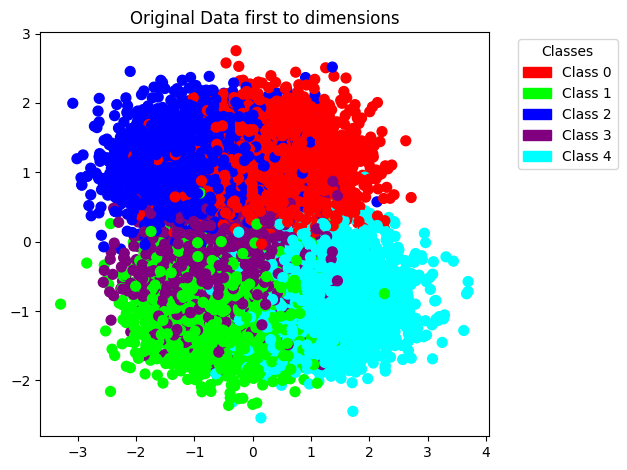

In [32]:

plt.figure()
plt.title('Original Data first to dimensions')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Semisupervised learning data


In [33]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y :\n {pd.Series(y).value_counts(normalize=False).sort_index()}")


Shape of X: (13600, 5), y: (13600,), X_unlabel: (13464, 5), y_unlabel: (13464,)
Frequencies of classes in y :
 -1    13464
 0       40
 1       24
 2       23
 3       24
 4       25
Name: count, dtype: int64


In [34]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val:\n {pd.Series(y_val).value_counts(normalize=False).sort_index()}")
print(f"Frequencies of classes in y_test:\n {pd.Series(y_test).value_counts(normalize=False).sort_index()}")


Shape of X_val: (136, 5), y_val: (136,), X_test: (3400, 5), y_test: (3400,)
Frequencies of classes in y_val:
 0    40
1    24
2    23
3    24
4    25
Name: count, dtype: int64
Frequencies of classes in y_test:
 0    680
1    680
2    680
3    680
4    680
Name: count, dtype: int64


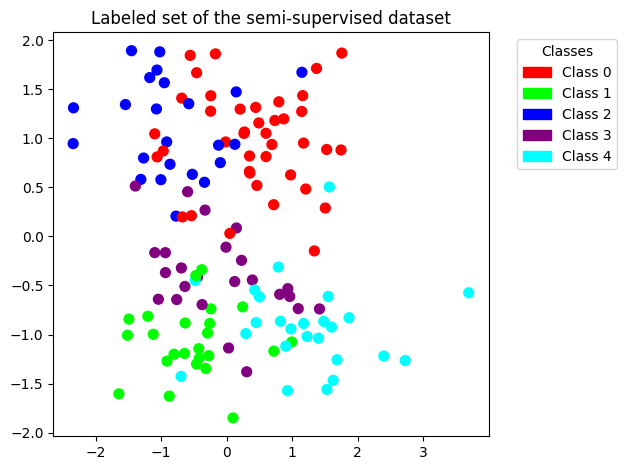

In [35]:
plt.figure()
plt.title('Labeled set of the semi-supervised dataset')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

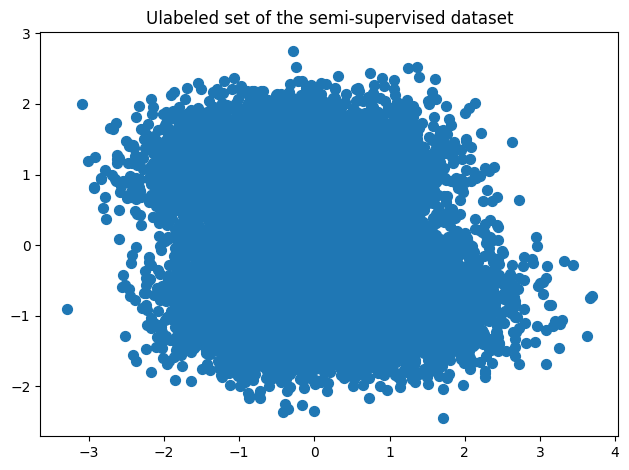

In [36]:
plt.figure()
plt.title('Ulabeled set of the semi-supervised dataset')
plt.scatter(X[y == -1,0], X[y == -1,1], marker= 'o', s=50)
plt.tight_layout()
plt.show()

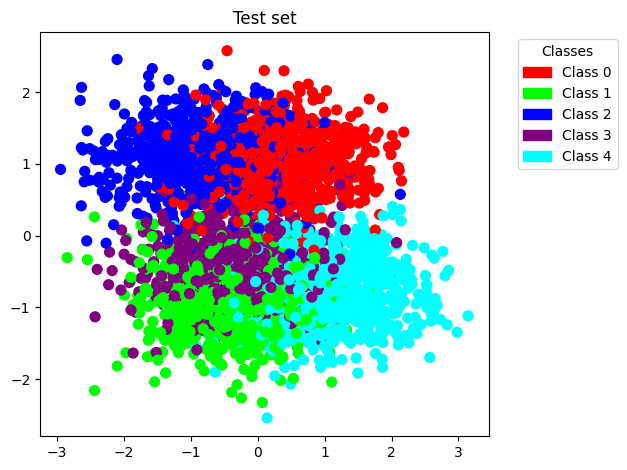

In [37]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)

unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [38]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

The shape of X_val: (136, 5)
The shape of y_val: (136,)
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [39]:
# Fit the base estimator on the validation set
dt_fitted = base_estimator_dt.fit(X_val, y_val)

## Evaluation metrics of the decision tree

In [40]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 0.9558823529411765
Accuracy of the base estimator on the test set: 0.7070588235294117
Classification report on validation set:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       1.00      1.00      1.00        24
           2       0.92      0.96      0.94        23
           3       0.92      1.00      0.96        24
           4       1.00      0.88      0.94        25

    accuracy                           0.96       136
   macro avg       0.96      0.96      0.96       136
weighted avg       0.96      0.96      0.96       136

Classification report on test set:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       680
           1       0.87      0.83      0.85       680
           2       0.73      0.86      0.79       680
           3       0.53      0.59      0.56       680
           4       0.82 

In [41]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


Accuracy of the base estimator on the unlabeled set: 0.7249702911467617
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      2680
           1       0.87      0.85      0.86      2696
           2       0.74      0.86      0.80      2697
           3       0.55      0.61      0.58      2696
           4       0.83      0.61      0.71      2695

    accuracy                           0.72     13464
   macro avg       0.73      0.72      0.73     13464
weighted avg       0.73      0.72      0.73     13464



# SETRED CLASSIFIER

In [42]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [43]:
# Fitting the Setred classifier
ssl_clf_dt = setred_scratch.Setred_scratch(base_estimator=base_estimator_dt,
                        graph_neighbors=10,
                        max_iterations=40,                             
                        htunning=True,
                        param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4, 5, 15]
                            },
                        X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                        y_test=y_test,
                        y_real_label = y_unlabel,                            
                        view =10)
ssl_clf_dt.fit(X, y)


---------------------------------------------------------------
-------------------Iteration 10 Started ------------
---------------------------------------------------------------
Distribution of real classes in the unlabeled set:
0    20
1    27
2    27
3    30
4    32
Name: count, dtype: int64
Distribution of the first  pseudolabel (predicted) candidates in the unlabeled set:
0    20
1    22
2    31
3    34
4    29
Name: count, dtype: int64
--------------------------------------------------------------
------Verification after filtering (Cut Edge Statistic)-------
--------------------------------------------------------------
Comparison between the filtered pseudolabels and the real labels of the unlabeled instances
Distribution of real classes in the unlabeled set:
0    20
1    24
2    25
3    28
4    30
Name: count, dtype: int64
Distribution of the filtered pseudolabels in the unlabeled set:
0    16
1    22
2    31
3    29
4    29
Name: count, dtype: int64
Iteration 10 - Accuracy:

Setred_scratch(X_test=array([[ 0.76265707, -0.9782696 ,  0.38984097, -0.29717653,  1.60650522],
       [ 0.46809851, -0.98903835,  0.82674711,  0.75384018,  0.80657413],
       [ 1.16941369, -1.32147955, -2.12202369, -1.87076809,  0.39791259],
       ...,
       [ 0.29886737, -0.52327837, -1.49256919,  0.29601702,  0.58883689],
       [-0.03174198, -0.64202884, -0.30770395,  0.65051042, -0.00426793],
       [ 1.14954041, -0.18678128, -0.57624576,  1.58956171,  0.25613887]]),
               base_estimator=DecisionTreeClassifier(min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=42),
               graph_neighbors=10, htunning=True,
               param_grid={'max_depth': [None, 5, 10, 15],
                           'min_samples_leaf': [1, 2, 4, 5, 15],
                           'min_samples_split': [2, 5, 10]},
               view=10, y_real_label=array([2, 3, 1, ..., 3, 0, 0]),
               y_test=array([1, 1, 4, ..., 3, 4, 4]))

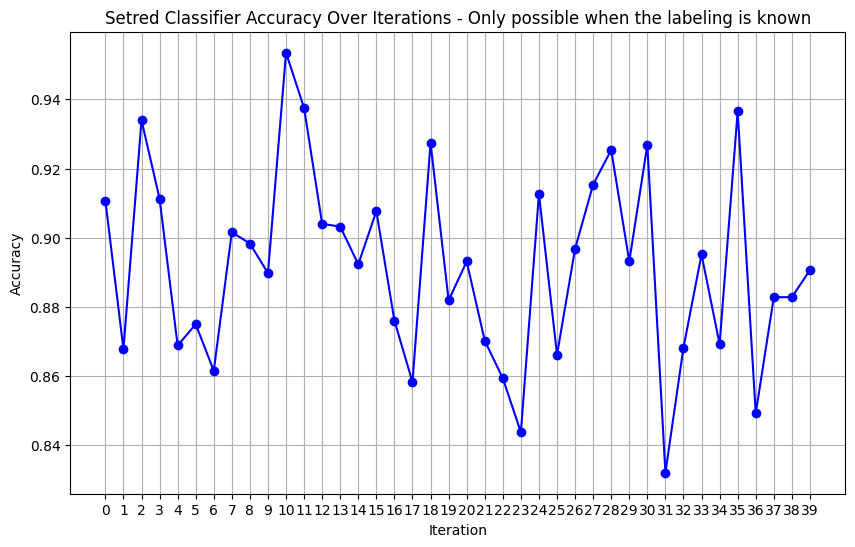

In [44]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_dt.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations - Only possible when the labeling is known')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_dt.accuracy_)))
plt.grid()



# Evaluation Metric

## Test

In [45]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_dt.predict(X_test)
accuracy_score_dt = base_estimator_dt.score(X_test, y_test)
print(f"Accuracy of the base estimator on the test set: {accuracy_score_dt}")
accuracy_score_setred = ssl_clf_dt.score(X_test, y_test)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_setred}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_setred - accuracy_score_dt}")
# The percentage of improvement
improvement = ((accuracy_score_setred - accuracy_score_dt )/ accuracy_score_dt) * 100
print(f"Percentage of improvement: {improvement:.2f}%")


Accuracy of the base estimator on the test set: 0.7070588235294117
Accuracy of the Setred classifier on the test set: 0.8105882352941176
Difference between the base estimator and the Setred classifier: 0.10352941176470587
Percentage of improvement: 14.64%


In [46]:
# Generate predictions on the test set
y_pred = base_estimator_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set with Base estimator:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set with Base estimator:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       680
           1       0.87      0.83      0.85       680
           2       0.73      0.86      0.79       680
           3       0.53      0.59      0.56       680
           4       0.82      0.55      0.66       680

    accuracy                           0.71      3400
   macro avg       0.72      0.71      0.71      3400
weighted avg       0.72      0.71      0.71      3400



In [47]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set with Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set with Setred:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       680
           1       0.87      0.89      0.88       680
           2       0.79      0.85      0.82       680
           3       0.74      0.66      0.70       680
           4       0.83      0.85      0.84       680

    accuracy                           0.81      3400
   macro avg       0.81      0.81      0.81      3400
weighted avg       0.81      0.81      0.81      3400



## Unlabel

In [48]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_dt.predict(X_unlabel)
accuracy_score_dt = base_estimator_dt.score(X_unlabel, y_unlabel)
print(f"Accuracy of the base estimator on the test set: {accuracy_score_dt}")
accuracy_score_setred = ssl_clf_dt.score(X_unlabel, y_unlabel)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_setred}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_setred - accuracy_score_dt}")
# The percentage of improvement
improvement = ((accuracy_score_setred - accuracy_score_dt )/ accuracy_score_dt) * 100
print(f"Percentage of improvement: {improvement:.2f}%")

Accuracy of the base estimator on the test set: 0.7249702911467617
Accuracy of the Setred classifier on the test set: 0.8283571004159239
Difference between the base estimator and the Setred classifier: 0.10338680926916222
Percentage of improvement: 14.26%


In [49]:
# Generate predictions on the test set
y_pred = base_estimator_dt.predict(X_unlabel)
# Generate the classification report
print("Classification report on test set with base estimator:")
report = classification_report(y_unlabel, y_pred)
print(report)

Classification report on test set with base estimator:
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      2680
           1       0.87      0.85      0.86      2696
           2       0.74      0.86      0.80      2697
           3       0.55      0.61      0.58      2696
           4       0.83      0.61      0.71      2695

    accuracy                           0.72     13464
   macro avg       0.73      0.72      0.73     13464
weighted avg       0.73      0.72      0.73     13464



In [50]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_unlabel)
# Generate the classification report
print("Classification report on test set with Setred:")
report = classification_report(y_unlabel, y_pred)
print(report)

Classification report on test set with Setred:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2680
           1       0.87      0.91      0.89      2696
           2       0.81      0.87      0.84      2697
           3       0.77      0.69      0.73      2696
           4       0.85      0.85      0.85      2695

    accuracy                           0.83     13464
   macro avg       0.83      0.83      0.83     13464
weighted avg       0.83      0.83      0.83     13464



# Comparison between the trees

In [51]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [52]:
names = [ "f" + str(i) for i in range(X.shape[1]) ]
names

['f0', 'f1', 'f2', 'f3', 'f4']

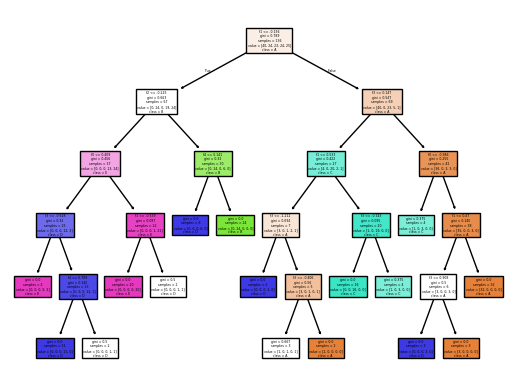

In [53]:
plot_tree(base_estimator_dt, feature_names=names, class_names=["A", "B","C","D","E"], filled=True)
plt.show()

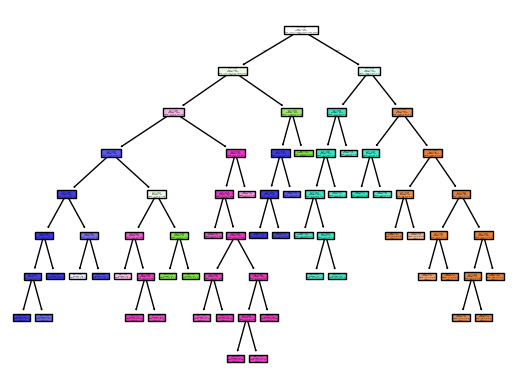

In [54]:
plot_tree(ssl_clf_dt._base_estimator, feature_names=names, class_names=["A", "B","C","D","E"], filled=True)
plt.show()